# Setup

In [2]:
import math 
from pandas_datareader import data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_fin.stock_info as si

from datetime import datetime
from datetime import timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import os
os.chdir(r'D:\Exercise\Prediction')

In [3]:
#Download Equity Data
tickers = 'AMZN'

start_date = datetime(2019,1,1)
end_date = datetime.today()

#Grab Online Data
df = si.get_data(tickers, start_date = start_date, end_date = end_date).reset_index().drop(columns = 'ticker')
df.columns = df.columns.str.capitalize()
df = df.rename(columns ={'Index':'Date'})
df

,Date,Open,High,Low,Close,Adjclose,Volume
0,2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,1539.130005,7983100
1,2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,1500.280029,6975600
2,2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,1575.390015,9182600
3,2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,1629.510010,7993200
4,2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,1656.579956,8881400
...,...,...,...,...,...,...,...
640,2021-07-19,3532.580078,3550.209961,3499.159912,3549.590088,3549.590088,3784600
641,2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700
642,2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000
643,2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3638.030029,3265400


# Exploratory Data Analysis

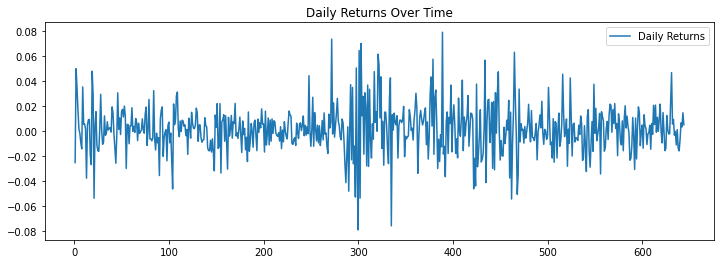

In [4]:
#Calcuate Return
df['Return'] = (df['Close'].pct_change())

#Calcuate Violatility
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
plt.show()

In [5]:
#Check Positive and Negative Return Days
print('Positive Return Day:', df[df.Return > 0]['Close'].count())
#Check Positive and Negative Return Days
print('Unchanged Day:', df[df.Return == 0]['Close'].count())
#Check Positive and Negative Return Days
print('Negative Return Day:', df[df.Return < 0]['Close'].count())
#Percentage of Positive Return
print('Percentage of Postitive Return:', df[df.Return > 0]['Close'].count()/ len(df))

Positive Return Day: 351
Unchanged Day: 0
Negative Return Day: 293
Percentage of Postitive Return: 0.5441860465116279


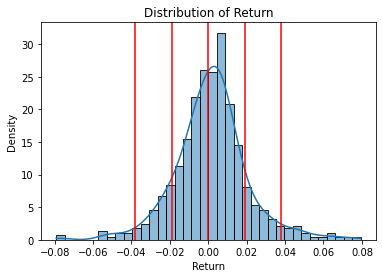

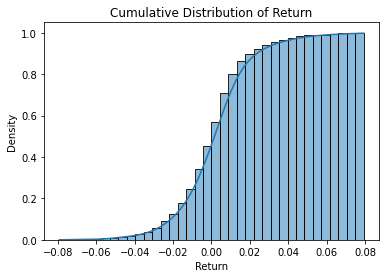

In [6]:
#SD and Percentile
stand_devt = df.Return.std()

#Check Distribution
sns.histplot(data=df, x="Return",stat = 'density', kde=True)
plt.axvline(0,color = 'Red')
plt.axvline(stand_devt,color = 'Red')
plt.axvline(-stand_devt,color = 'Red')
plt.axvline(stand_devt*2,color = 'Red')
plt.axvline(-stand_devt*2,color = 'Red')
plt.title('Distribution of Return')
plt.show()

# Cumculative Distribution
sns.histplot(data=df, x="Return",stat = 'density', cumulative = True, kde=True)
plt.title('Cumulative Distribution of Return')
plt.show()

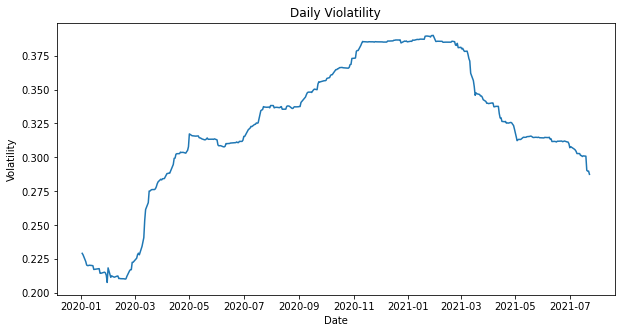

In [7]:
# Annual Violatility
df['Volatility'] = df.Return.rolling(window=252).std()*np.sqrt(252)

plt.figure(figsize=(10, 5))
sns.lineplot(data = df,x = 'Date', y= 'Volatility')
plt.title('Daily Violatility')
plt.show()

In [8]:
df

,Date,Open,High,Low,Close,Adjclose,Volume,Return,Volatility
0,2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,1539.130005,7983100,NaN,NaN
1,2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,1500.280029,6975600,-0.025242,NaN
2,2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,1575.390015,9182600,0.050064,NaN
3,2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,1629.510010,7993200,0.034353,NaN
4,2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,1656.579956,8881400,0.016612,NaN
...,...,...,...,...,...,...,...,...,...
640,2021-07-19,3532.580078,3550.209961,3499.159912,3549.590088,3549.590088,3784600,-0.006727,0.300914
641,2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700,0.006649,0.290500
642,2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000,0.003361,0.289891
643,2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3638.030029,3265400,0.014736,0.289938


# Fundamentals and Valuation

In [9]:
#Import Past 3 Fundamental Data to Calcuate PE PS Ratio
Income_statment = si.get_income_statement(tickers, yearly = False).transpose().reset_index().fillna(0)
Income_statment = Income_statment[['endDate','ebit','netIncome','totalRevenue','minorityInterest']]
Income_statment

Breakdown,endDate,ebit,netIncome,totalRevenue,minorityInterest
0,2021-03-31,10865000000,8107000000,108518000000,0
1,2020-12-31,6873000000,7222000000,125555000000,0
2,2020-09-30,6194000000,6331000000,96145000000,0
3,2020-06-30,5843000000,5243000000,88912000000,0


In [10]:
Balance_statement = si.get_balance_sheet(tickers, yearly = False).transpose().reset_index().fillna(0)
Balance_statement = Balance_statement[['endDate','commonStock', 'cash','shortLongTermDebt']]
Balance_statement['commonStock'] = Balance_statement['commonStock']*100
Balance_statement

Breakdown,endDate,commonStock,cash,shortLongTermDebt
0,2021-03-31,500000000.0,3.383400e+10,1.156000e+09
1,2020-12-31,500000000.0,4.212200e+10,1.155000e+09
2,2020-09-30,500000000.0,2.993000e+10,1.550000e+08
3,2020-06-30,500000000.0,3.746600e+10,1.154000e+09


In [11]:
Cashflow_statement = si.get_cash_flow(tickers, yearly = False).transpose().reset_index().fillna(0)
Cashflow_statement = Cashflow_statement[['endDate','depreciation']]
Cashflow_statement

Breakdown,endDate,depreciation
0,2021-03-31,7508000000
1,2020-12-31,7618000000
2,2020-09-30,6523000000
3,2020-06-30,5748000000


In [12]:
Combined_Statement = pd.merge(Income_statment, Balance_statement, on ='endDate', how = 'inner')
Combined_Statement = pd.merge(Combined_Statement, Cashflow_statement, on ='endDate', how = 'inner')
Combined_Statement = Combined_Statement.rename(columns = {'endDate':'Date',
                                                          'ebit': 'EBIT',
                                                          'netIncome': 'Earning',
                                                          'totalRevenue': 'Revenue',
                                                          'commonStock': 'Outstanding Shares',
                                                          'cash': 'Cash',
                                                          'shortLongTermDebt': 'Debt',
                                                          'minorityInterest': 'Minority Interest',
                                                          'depreciation': 'Depreciation'
                                                         })
Combined_Statement

Breakdown,Date,EBIT,Earning,Revenue,Minority Interest,Outstanding Shares,Cash,Debt,Depreciation
0,2021-03-31,10865000000,8107000000,108518000000,0,500000000.0,3.383400e+10,1.156000e+09,7508000000
1,2020-12-31,6873000000,7222000000,125555000000,0,500000000.0,4.212200e+10,1.155000e+09,7618000000
2,2020-09-30,6194000000,6331000000,96145000000,0,500000000.0,2.993000e+10,1.550000e+08,6523000000
3,2020-06-30,5843000000,5243000000,88912000000,0,500000000.0,3.746600e+10,1.154000e+09,5748000000


In [13]:
#Convert to a Daily
Daily_Fundamnetals = pd.DataFrame(pd.date_range(min(Combined_Statement.Date), max(Combined_Statement.Date)), columns = ['Date'])
Daily_Fundamnetals = pd.merge(Daily_Fundamnetals, Combined_Statement, on = 'Date', how = 'left')
Daily_Fundamnetals.fillna(method = 'backfill', inplace = True)

In [14]:
Daily_Fundamnetals.columns

Index(['Date', 'EBIT', 'Earning', 'Revenue', 'Minority Interest',
       'Outstanding Shares', 'Cash', 'Debt', 'Depreciation'],
      dtype='object')

In [15]:
df = pd.merge(df, Daily_Fundamnetals, on ='Date', how = 'left')

for i in ['EBIT', 'Earning', 'Revenue', 'Minority Interest',
       'Outstanding Shares', 'Cash', 'Debt', 'Depreciation']:
    df[i].fillna(method = 'bfill', inplace = True)
    df[i].fillna(method = 'ffill', inplace = True)
    
df = df[df.Date >= min(Combined_Statement.Date)].reset_index(drop = True)
df

,Date,Open,High,Low,Close,Adjclose,Volume,Return,Volatility,EBIT,Earning,Revenue,Minority Interest,Outstanding Shares,Cash,Debt,Depreciation
0,2020-06-30,2685.070068,2769.629883,2675.030029,2758.820068,2758.820068,3769700,0.029265,0.312730,5.843000e+09,5.243000e+09,8.891200e+10,0.0,500000000.0,3.746600e+10,1.154000e+09,5.748000e+09
1,2020-07-01,2757.989990,2895.000000,2754.000000,2878.699951,2878.699951,6363400,0.043453,0.315482,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
2,2020-07-02,2912.010010,2955.560059,2871.100098,2890.300049,2890.300049,6593400,0.004030,0.315490,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
3,2020-07-06,2934.969971,3059.879883,2930.000000,3057.040039,3057.040039,6880600,0.057690,0.320405,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
4,2020-07-07,3058.550049,3069.550049,2990.000000,3000.120117,3000.120117,5257500,-0.018619,0.321055,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2021-07-19,3532.580078,3550.209961,3499.159912,3549.590088,3549.590088,3784600,-0.006727,0.300914,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09
265,2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700,0.006649,0.290500,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09
266,2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000,0.003361,0.289891,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09
267,2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3638.030029,3265400,0.014736,0.289938,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09


In [16]:
si.get_stats_valuation(tickers)

,0,1
0,Market Cap (intraday) 5,1.84T
1,Enterprise Value 3,1.87T
2,Trailing P/E,69.57
3,Forward P/E 1,50.52
4,PEG Ratio (5 yr expected) 1,1.66
5,Price/Sales (ttm),4.40
6,Price/Book (mrq),17.84
7,Enterprise Value/Revenue 3,4.47
8,Enterprise Value/EBITDA 7,32.75


In [17]:
df['Market Cap'] = df['Close'] * df['Outstanding Shares']
df['EBITDA'] = df['EBIT'] + df['Debt'] + df['Depreciation']
df['EV'] = df['Market Cap'] + df['Debt'] + df['Minority Interest'] - df['Cash']
df['EV/EBITDA'] = df['EV']/sum(np.unique(df['EBITDA']))
df['Earning Per Share'] = df['Earning']/df['Outstanding Shares']
df['Earning Per Share (TTM)'] = np.unique(df['Earning Per Share']).sum()
df['P/E Ratio'] = df['Close']/df['Earning Per Share (TTM)']
df['P/S Ratio'] = df['Market Cap']/np.unique(df['Revenue']).sum()
df.set_index('Date', inplace = True)
df

,Open,High,Low,Close,Adjclose,Volume,Return,Volatility,EBIT,Earning,...,Debt,Depreciation,Market Cap,EBITDA,EV,EV/EBITDA,Earning Per Share,Earning Per Share (TTM),P/E Ratio,P/S Ratio
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,2685.070068,2769.629883,2675.030029,2758.820068,2758.820068,3769700,0.029265,0.312730,5.843000e+09,5.243000e+09,...,1.154000e+09,5.748000e+09,1.379410e+12,1.274500e+10,1.343098e+12,22.093335,10.486,53.806,51.273465,3.291127
2020-07-01,2757.989990,2895.000000,2754.000000,2878.699951,2878.699951,6363400,0.043453,0.315482,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.439350e+12,1.287200e+10,1.409575e+12,23.186850,12.662,53.806,53.501467,3.434137
2020-07-02,2912.010010,2955.560059,2871.100098,2890.300049,2890.300049,6593400,0.004030,0.315490,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.445150e+12,1.287200e+10,1.415375e+12,23.282258,12.662,53.806,53.717058,3.447976
2020-07-06,2934.969971,3059.879883,2930.000000,3057.040039,3057.040039,6880600,0.057690,0.320405,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.528520e+12,1.287200e+10,1.498745e+12,24.653655,12.662,53.806,56.815969,3.646888
2020-07-07,3058.550049,3069.550049,2990.000000,3000.120117,3000.120117,5257500,-0.018619,0.321055,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.500060e+12,1.287200e+10,1.470285e+12,24.185502,12.662,53.806,55.758096,3.578985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-19,3532.580078,3550.209961,3499.159912,3549.590088,3549.590088,3784600,-0.006727,0.300914,1.086500e+10,8.107000e+09,...,1.156000e+09,7.508000e+09,1.774795e+12,1.952900e+10,1.742117e+12,28.657012,16.214,53.806,65.970154,4.234474
2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700,0.006649,0.290500,1.086500e+10,8.107000e+09,...,1.156000e+09,7.508000e+09,1.786595e+12,1.952900e+10,1.753917e+12,28.851115,16.214,53.806,66.408764,4.262627
2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000,0.003361,0.289891,1.086500e+10,8.107000e+09,...,1.156000e+09,7.508000e+09,1.792600e+12,1.952900e+10,1.759922e+12,28.949894,16.214,53.806,66.631973,4.276955


In [18]:
df = df[['Close','Volume','Return','Volatility','Earning','Revenue',
         'Earning Per Share', 'Earning Per Share (TTM)','P/E Ratio', 'P/S Ratio','EV/EBITDA','Cash']]
df

,Close,Volume,Return,Volatility,Earning,Revenue,Earning Per Share,Earning Per Share (TTM),P/E Ratio,P/S Ratio,EV/EBITDA,Cash
Date,,,,,,,,,,,,
2020-06-30,2758.820068,3769700,0.029265,0.312730,5.243000e+09,8.891200e+10,10.486,53.806,51.273465,3.291127,22.093335,3.746600e+10
2020-07-01,2878.699951,6363400,0.043453,0.315482,6.331000e+09,9.614500e+10,12.662,53.806,53.501467,3.434137,23.186850,2.993000e+10
2020-07-02,2890.300049,6593400,0.004030,0.315490,6.331000e+09,9.614500e+10,12.662,53.806,53.717058,3.447976,23.282258,2.993000e+10
2020-07-06,3057.040039,6880600,0.057690,0.320405,6.331000e+09,9.614500e+10,12.662,53.806,56.815969,3.646888,24.653655,2.993000e+10
2020-07-07,3000.120117,5257500,-0.018619,0.321055,6.331000e+09,9.614500e+10,12.662,53.806,55.758096,3.578985,24.185502,2.993000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-19,3549.590088,3784600,-0.006727,0.300914,8.107000e+09,1.085180e+11,16.214,53.806,65.970154,4.234474,28.657012,3.383400e+10
2021-07-20,3573.189941,3255700,0.006649,0.290500,8.107000e+09,1.085180e+11,16.214,53.806,66.408764,4.262627,28.851115,3.383400e+10
2021-07-21,3585.199951,2319000,0.003361,0.289891,8.107000e+09,1.085180e+11,16.214,53.806,66.631973,4.276955,28.949894,3.383400e+10


# Neuron Netowork

In [18]:
#Window the Data by Pandas Shift Function
neuron_df = df.copy()
columns_name = neuron_df.columns
shift_day = 4

for i in columns_name:
    for j in range(1,shift_day + 1):
        neuron_df[f'{i} t-{j}'] = neuron_df[i].shift(j)

neuron_df = neuron_df[j:].drop(columns = columns_name.drop('Close'))
neuron_df

,Close,Close t-1,Close t-2,Close t-3,Close t-4,Volume t-1,Volume t-2,Volume t-3,Volume t-4,Return t-1,...,P/S Ratio t-3,P/S Ratio t-4,EV/EBITDA t-1,EV/EBITDA t-2,EV/EBITDA t-3,EV/EBITDA t-4,Cash t-1,Cash t-2,Cash t-3,Cash t-4
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-07,3000.120117,3057.040039,2890.300049,2878.699951,2758.820068,6880600.0,6593400.0,6363400.0,3769700.0,0.057690,...,3.434137,3.291127,24.653655,23.282258,23.186850,22.093335,2.993000e+10,2.993000e+10,2.993000e+10,3.746600e+10
2020-07-08,3081.110107,3000.120117,3057.040039,2890.300049,2878.699951,5257500.0,6880600.0,6593400.0,6363400.0,-0.018619,...,3.447976,3.434137,24.185502,24.653655,23.282258,23.186850,2.993000e+10,2.993000e+10,2.993000e+10,2.993000e+10
2020-07-09,3182.629883,3081.110107,3000.120117,3057.040039,2890.300049,5037600.0,5257500.0,6880600.0,6593400.0,0.026996,...,3.646888,3.447976,24.851626,24.185502,24.653655,23.282258,2.993000e+10,2.993000e+10,2.993000e+10,2.993000e+10
2020-07-10,3200.000000,3182.629883,3081.110107,3000.120117,3057.040039,6388700.0,5037600.0,5257500.0,6880600.0,0.032949,...,3.578985,3.646888,25.686603,24.851626,24.185502,24.653655,2.993000e+10,2.993000e+10,2.993000e+10,2.993000e+10
2020-07-13,3104.000000,3200.000000,3182.629883,3081.110107,3000.120117,5486000.0,6388700.0,5037600.0,5257500.0,0.005458,...,3.675602,3.578985,25.829468,25.686603,24.851626,24.185502,2.993000e+10,2.993000e+10,2.993000e+10,2.993000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-19,3549.590088,3573.629883,3631.199951,3681.679932,3677.360107,4038400.0,3185300.0,3296600.0,3845900.0,-0.015854,...,4.392050,4.386897,28.854733,29.328234,29.743420,29.707890,3.383400e+10,3.383400e+10,3.383400e+10,3.383400e+10
2021-07-20,3573.189941,3549.590088,3573.629883,3631.199951,3681.679932,3784600.0,4038400.0,3185300.0,3296600.0,-0.006727,...,4.331830,4.392050,28.657012,28.854733,29.328234,29.743420,3.383400e+10,3.383400e+10,3.383400e+10,3.383400e+10
2021-07-21,3585.199951,3573.189941,3549.590088,3573.629883,3631.199951,3255700.0,3784600.0,4038400.0,3185300.0,0.006649,...,4.263152,4.331830,28.851115,28.657012,28.854733,29.328234,3.383400e+10,3.383400e+10,3.383400e+10,3.383400e+10


In [19]:
# Train Test Actual Split
portion = np.linspace(0, len(df), 10).round().astype(int)

X = neuron_df.drop(columns = ['Close'])
y = neuron_df['Close']

# Data Normalization 
columns_name = X.columns
scaler = StandardScaler() 
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = columns_name

X_train, y_train = X[:portion[6]], y[:portion[6]]
X_test, y_test = X[portion[6]:portion[8]], y[portion[6]:portion[8]] 
X_actual, y_actual = X[portion[8]:] , y[portion[8]:] 
print(X_train.shape, X_test.shape, X_actual.shape)

(179, 48) (60, 48) (26, 48)


In [20]:
#Defining Early Stopping 
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

#Defining Neural Model
DL_Model =  keras.Sequential([
    keras.layers.Dense(24,
                       input_shape = [len(X_train.columns)],
                       activation='relu',
                       kernel_regularizer='l2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8,
                       kernel_regularizer='l2'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1),
])

#Compile Model Fit
DL_Model.compile(
    optimizer= keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.0),
    loss=['mean_squared_error'],
    metrics = ['mean_squared_error']
)

In [21]:
#Record The Epoch 
History = DL_Model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    callbacks =early_stopping,
    batch_size=32,
    epochs=1000,
    verbose=0,
)

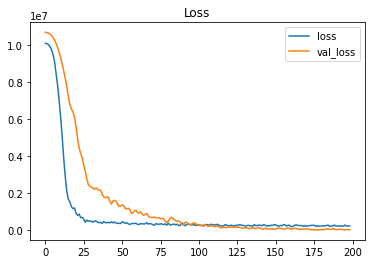

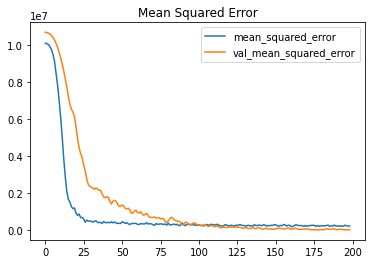

In [22]:
# Convert the Training History to a Dataframe
history_df = pd.DataFrame(History.history)
#Pandas native plot method
history_df.loc[:, ['loss', 'val_loss']].plot();
plt.title('Loss')
plt.show()
history_df.loc[:, ['mean_squared_error', 'val_mean_squared_error']].plot()
plt.title('Mean Squared Error')
plt.show()

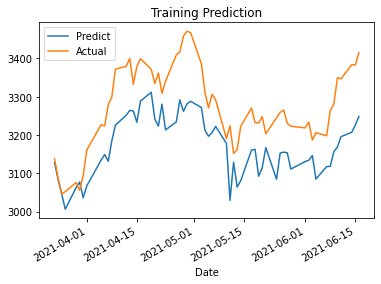

In [23]:
Results = pd.DataFrame(DL_Model.predict(X_test))
Results.columns = ['Predict']
Results['Actual'] = y_test.values
Results.index = y_test.index
Results.plot()
plt.title('Training Prediction')
plt.show()

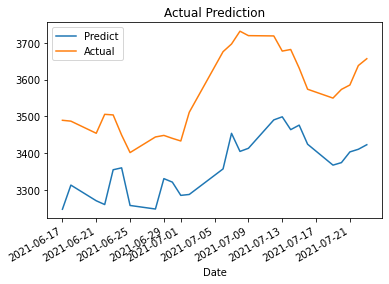

In [24]:
Results = pd.DataFrame(DL_Model.predict(X_actual))
Results.columns = ['Predict']
Results['Actual'] =y_actual.values
Results.index = y_actual.index
Results.plot()
plt.title('Actual Prediction')
plt.show()

In [25]:
#Predict Next Close Price
Prediction = df[-j-1:]
columns_name = Prediction.columns

for i in columns_name:
    for j in range(1,shift_day + 1):
        Prediction[f'{i} t-{j}'] = Prediction[i].shift(j)
        
Prediction = Prediction[-1:].drop(columns = columns_name)
columns_name = Prediction.columns

Prediction = pd.DataFrame(scaler.transform(Prediction))
Prediction.columns = columns_name
Prediction

<ipython-input-25-045ebcd397aa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Prediction[f'{i} t-{j}'] = Prediction[i].shift(j)


,Close t-1,Close t-2,Close t-3,Close t-4,Volume t-1,Volume t-2,Volume t-3,Volume t-4,Return t-1,Return t-2,...,P/S Ratio t-3,P/S Ratio t-4,EV/EBITDA t-1,EV/EBITDA t-2,EV/EBITDA t-3,EV/EBITDA t-4,Cash t-1,Cash t-2,Cash t-3,Cash t-4
0,2.548406,2.239171,2.179856,2.033591,-0.594655,-1.246313,-0.61668,-0.257703,0.713046,0.122555,...,2.179856,2.033591,2.553914,2.247224,2.189277,2.043238,-0.24985,-0.245889,-0.241951,-0.244951


In [26]:
DL_Model.predict(Prediction)

array([[3422.804]], dtype=float32)

# Simulation

In [27]:
def simulation(iteration):
    
    #Window the Data by Pandas Shift Function
    neuron_df = df.copy()
    columns_name = neuron_df.columns
    shift_day = 4

    for i in columns_name:
        for j in range(1,shift_day + 1):
            neuron_df[f'{i} t-{j}'] = neuron_df[i].shift(j)

    neuron_df = neuron_df[j:].drop(columns = columns_name.drop('Close'))

    # Train Test Actual Split
    portion = np.linspace(0, len(df), 10).round().astype(int)

    X = neuron_df.drop(columns = ['Close'])
    y = neuron_df['Close']

    # Data Normalization 
    columns_name = X.columns
    scaler = StandardScaler() 
    scaler.fit(X)
    X = pd.DataFrame(scaler.transform(X))
    X.columns = columns_name

    X_train, y_train = X[:portion[6]], y[:portion[6]]
    X_test, y_test = X[portion[6]:portion[8]], y[portion[6]:portion[8]] 
    X_actual, y_actual = X[portion[8]:] , y[portion[8]:] 
    print('Training Size', X_train.shape, '\nTest Size', X_test.shape, '\nActual Size', X_actual.shape)
    
    #Defining Early Stopping 
    early_stopping = keras.callbacks.EarlyStopping(
        min_delta=0.01, # minimium amount of change to count as an improvement
        patience=20, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    #Defining Neural Model
    DL_Model =  keras.Sequential([
        keras.layers.Dense(24,
                           input_shape = [len(X_train.columns)],
                           activation='relu',
                           kernel_regularizer='l2'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(8,
                           kernel_regularizer='l2'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1),
    ])

    #Compile Model Fit
    DL_Model.compile(
        optimizer= keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.0),
        loss=['mean_squared_error'],
        metrics = ['mean_squared_error']
    )
    
    Records = []
    
    for num in range(iteration):

        #Record The Epoch 
        DL_Model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            callbacks =early_stopping,
            batch_size=32,
            epochs=1000,
            verbose=0,
        )

        #Predict Next Close Price
        Prediction = df[-j-1:]
        columns_name = Prediction.columns

        for i in columns_name:
            for j in range(1,shift_day + 1):
                Prediction[f'{i} t-{j}'] = Prediction[i].shift(j)

        Prediction = Prediction[-1:].drop(columns = columns_name)
        columns_name = Prediction.columns

        Prediction = pd.DataFrame(scaler.transform(Prediction))
        Prediction.columns = columns_name
        
        Records.append(DL_Model.predict(Prediction).flatten()[0])
        
        if num in np.linspace(1, iteration, 10).round():
            print(num)
    
    return Records

In [28]:
pd.options.mode.chained_assignment = None
Predict_List = simulation(1000)
Predict_List

Training Size (179, 48) 
Test Size (60, 48) 
Actual Size (26, 48)
1
112
223
334
445
556
667
778
889


[3650.4485,
 3623.901,
 3585.4707,
 3575.071,
 3545.9973,
 3545.4165,
 3596.1392,
 3528.5295,
 3580.6309,
 3585.0945,
 3560.883,
 3552.2979,
 3606.0488,
 3601.9543,
 3666.0354,
 3641.9048,
 3518.4316,
 3518.3335,
 3609.026,
 3647.7053,
 3582.4673,
 3642.561,
 3608.8853,
 3641.316,
 3568.3516,
 3599.3499,
 3588.914,
 3602.2861,
 3643.7295,
 3615.1013,
 3575.085,
 3614.7524,
 3660.9243,
 3600.637,
 3607.8923,
 3624.733,
 3653.8955,
 3660.043,
 3638.8374,
 3651.2317,
 3661.1995,
 3613.0012,
 3657.8486,
 3622.466,
 3650.6572,
 3649.883,
 3655.128,
 3673.2954,
 3616.4595,
 3627.1523,
 3665.605,
 3632.0322,
 3657.099,
 3682.9224,
 3683.0103,
 3653.8218,
 3697.12,
 3660.5688,
 3631.179,
 3670.1274,
 3664.3293,
 3618.5442,
 3638.7402,
 3644.8433,
 3659.4744,
 3668.4395,
 3628.3318,
 3662.3584,
 3680.2368,
 3657.4824,
 3629.2178,
 3647.5981,
 3597.1792,
 3601.5986,
 3636.6528,
 3623.9084,
 3730.8196,
 3687.8923,
 3666.2012,
 3655.294,
 3690.689,
 3670.7769,
 3724.663,
 3713.6309,
 3679.4773,
 3

In [29]:
#Check Distribution
STD = np.array(Predict_List).std()
Mean = np.array(Predict_List).mean()
Up_Q = np.quantile(np.array(Predict_List), .75)
Median = np.quantile(np.array(Predict_List), .5)
Low_Q = np.quantile(np.array(Predict_List), .25)

print('Prediction STD:', STD)
print('Prediction Mean:', Mean)
print('Prediction Upper Quantile:', Up_Q)
print('Prediction Median:', Median)
print('Prediction Lower Quantile:', Low_Q)

Prediction STD: 55.777836
Prediction Mean: 3670.579
Prediction Upper Quantile: 3705.5758056640625
Prediction Median: 3669.3055419921875
Prediction Lower Quantile: 3637.10546875


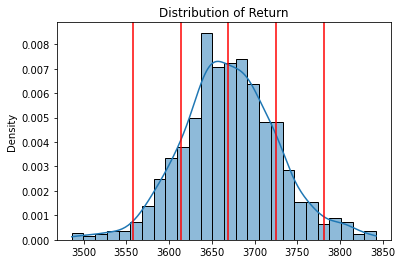

In [30]:
sns.histplot(data=Predict_List,stat = 'density', kde=True)
plt.axvline(Median,color = 'Red')
plt.axvline(Median + STD ,color = 'Red')
plt.axvline(Median - STD ,color = 'Red')
plt.axvline(Median + STD*2,color = 'Red')
plt.axvline(Median - STD*2,color = 'Red')
plt.title('Distribution of Return')
plt.show()

In [31]:
#Prediction Projection
from dateutil.relativedelta import relativedelta
Projection = pd.DataFrame({'Permessistic': df['Close'],
                           'Neutral': df['Close'],
                           'Optimistic': df['Close']
                          })
Predict_Projection = pd.DataFrame({'Permessistic': [Low_Q],
                                   'Neutral': [Median],
                                   'Optimistic': [Up_Q]
                                  })
Predict_Projection.index = [max(Projection.index) + timedelta(1)]

Projection = Projection.append(Predict_Projection)
Projection.index =pd.to_datetime(Projection.index)
Projection

,Permessistic,Neutral,Optimistic
2020-06-30,2758.820068,2758.820068,2758.820068
2020-07-01,2878.699951,2878.699951,2878.699951
2020-07-02,2890.300049,2890.300049,2890.300049
2020-07-06,3057.040039,3057.040039,3057.040039
2020-07-07,3000.120117,3000.120117,3000.120117
...,...,...,...
2021-07-20,3573.189941,3573.189941,3573.189941
2021-07-21,3585.199951,3585.199951,3585.199951
2021-07-22,3638.030029,3638.030029,3638.030029
2021-07-23,3656.639893,3656.639893,3656.639893


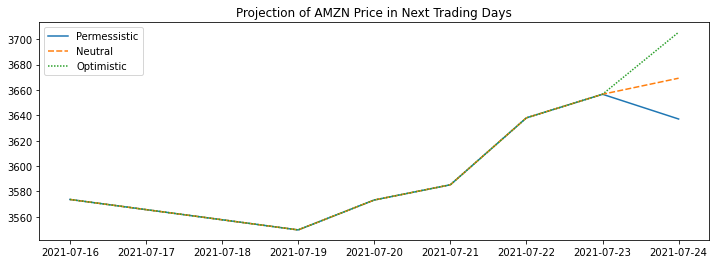

<Figure size 720x360 with 0 Axes>

In [32]:
fig = plt.figure()
fig.set_figwidth(12)
sns.lineplot(data = Projection[-7:])
plt.title(f'Projection of {tickers} Price in Next Trading Days')
plt.figure(figsize=(10, 5))
plt.show()